# Softmax Classifier

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=3, suppress=True)

## Class Softmax

This is the implementation of the linear Softmax classifier:
* The Python class has two metods: `train(X, Y)` and `Y = predict(X)`.
* Matrix `self.W` is the weight matrix and also includes the bias vector ([bias tricks](https://cs231n.github.io/linear-classify/#interpreting-a-linear-classifier)).
* Training is done by using stochastic gradient descent method.

Let us define the score function as linear combination of all feature values.

$ F = X W$

$ \text{softmax}(i) = e^{F_{Y_{i}}} \Big/ \sum_{j=1}^C e^{F_{i}} $

$ L_{i}=-\log \left( \text{softmax}(i) \right) $

$ L=\underbrace{\frac{1}{N} \sum_{i=1}^N L_{i}}_{\text {data loss }}+\underbrace{\lambda R(W)}_{\text {regularization loss }} $

$ R(W) = \sum_{k=1}^C \sum_{l=1}^{D+1} W_{l, k}^{2} $

where:
- the dataset contains $N$ samples of data
- each sample has $D$ features (dimensionalities) and $C$ labels/classes (distinct categories)
- $X \in \mathbb{R}^{N \times (D+1)}$ contains the features from N samples of data
- $X_i \in \mathbb{R}^{D+1}$ contains the features of the $i$-th sample ($i$-th row of $X$)
- $Y \in \mathbb{R}^{N}$ contains the labels from N samples of data
- $Y_i \in \mathbb{R}$ contains the label of the $i$-th sample ($i$-th row of $Y$)
- $F_i \in \mathbb{R}^{C}$ is the scores for all classes of $i$-th sample
- $F_{y_i} \in \mathbb{R}$ is the score for the correct class of $i$-th sample
- $L \in \mathbb{R}$ is the total loss
- $L_i \in \mathbb{R}$ is the loss of $i$-th sample
- $W \in \mathbb{R}^{(D+1) \times C}$ is the weight matrix (with augmented bias vector in the last row)
- $R \in \mathbb{R}$ is the regularization loss

In [2]:
from numba import njit, prange

class Softmax():
    @staticmethod
    @njit(parallel=True, fastmath=True)
    def softmax_loss(W, X, Y, reg):
        """
        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D+1, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - Y: A numpy array of shape (N,) containing training labels; Y[i] = c means
          that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss: loss as single float
        - dW: gradient with respect to weights W; an array of same shape as W

        References:
        - https://github.com/lightaime/cs231n
        - https://github.com/mantasu/cs231n
        - https://github.com/jariasf/CS231n
        
        """
        # Initialize the loss and gradient to zero.
        loss = 0.0
        dW   = np.zeros_like(W)
        
        N = X.shape[0] # samples 
        C = W.shape[1] # classes
        X = np.hstack((X, np.ones((N, 1)))) # the last column is 1: to allow augmentation of bias vector into W

        F = X@W 

        # Softmax Loss
        for i in prange(N):
            Fi = F[i] - np.max(F[i])
            expFi = np.exp(Fi)
            softmax = expFi/np.sum(expFi) 
            loss += -np.log(softmax[Y[i]])

            # Weight Gradients
            for j in prange(C):
                dW[:, j] += X[i] * softmax[j]
            dW[:, Y[i]] -= X[i]

        # Average
        loss /= N
        dW /= N

        # Regularization
        loss += reg * np.sum(W * W)
        dW += reg * 2 * W 

        return loss, dW
 

    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=True):
        '''
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - Y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        '''
          
        N, D = X.shape
        C = len(np.unique(Y)) 
        
        # lazily initialize W
        self.W = 0.001 * np.random.randn(D+1, C) # dim+1, to bias vector is augmented into W 

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            # Store the data in X_batch and their corresponding labels in           
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   
            # and y_batch should have shape (batch_size,)                           
            
            batch_indices = np.random.choice(N, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = Y[batch_indices]
            
            # evaluate loss and gradient
            loss, grad = self.softmax_loss(self.W, X_batch, y_batch, reg)
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          
            self.W = self.W - learning_rate * grad
     
            if verbose and it % 5000 == 0:
                print('iteration', it, 'of', num_iters, 'loss', loss, flush=True)

        return loss_history
    

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - Y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        
        X  = np.hstack((X, np.ones((X.shape[0],1))))

        Y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        Y_pred = scores.argmax(axis=1)

        return Y_pred

## Heart Disease Prediction

The original labels are characters: `Presence` and `Absence`. For the SVM to work, the labels must be numbers. Hence, we change the labels:
* `Presence` is replaced with `1`
* `Absence` is replaced with `0`

### Load the Dataset

In [4]:
data1 = np.genfromtxt("./datasets/heart/Heart_Disease_Prediction.csv", delimiter=",", dtype=str, skip_header=1)
X1 = np.float32(data1[:, 0:13])  # 13 dimensions

Y1 = np.zeros(X1.shape[0], dtype=np.int32) 
Y1[np.where(data1[:,13]=='Presence')] = 1
Y1[np.where(data1[:,13]=='Absence')] = 0

print("Dimension numbers :", X1.shape[1])
print("Number of data    :", X1.shape[0])
print("Labels            :", np.unique(Y1))

Dimension numbers : 13
Number of data    : 270
Labels            : [0 1]


### Split The Dataset for Training and Test

In [5]:
X_train1 = X1[0:189, :]
y_train1 = Y1[0:189]
X_test1  = X1[190:, :]
Y_test1  = Y1[190:]

num_test1 = X_test1.shape[0]

### Train the Classifier

In [6]:
classifier1 = Softmax()
loss_hist1 = classifier1.train(X_train1, y_train1, learning_rate=1e-6,batch_size=100, reg=0.1, num_iters=10000)

iteration 0 of 10000 loss 0.6959568028341665
iteration 5000 of 10000 loss 0.5982502274627383


### Plot the Loss

Plot the loss as a function of iteration number.

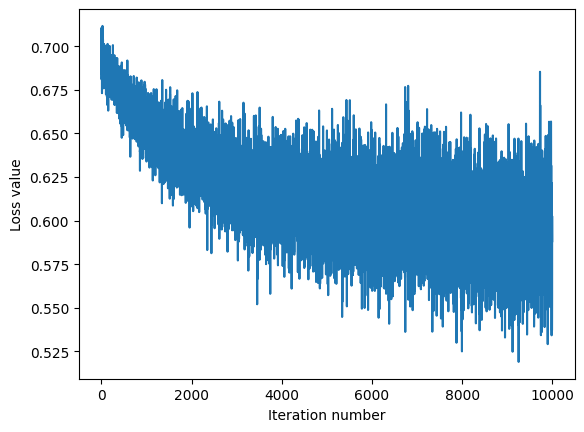

In [7]:
plt.plot(loss_hist1)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Test the Classifier
Evaluate the performance on both the training and validation set.

In [8]:
Y_train_pred1 = classifier1.predict(X_train1)
print('training accuracy: %f' % (np.mean(y_train1 == Y_train_pred1), ))
Y_test_pred1 = classifier1.predict(X_test1)
print('validation accuracy: %f' % (np.mean(Y_test1 == Y_test_pred1), ))

training accuracy: 0.661376
validation accuracy: 0.700000
